# DVF Grenoble — Forêt aléatoire (RandomForest)
Modélisation prédictive des prix immobiliers à Grenoble avec RandomForestRegressor.
Objectifs: charger les données prétraitées, créer des variantes (log, standardisation), entraîner des forêts aléatoires, évaluer et visualiser les performances et importances.

## Plan du notebook
1. Importations et configuration
2. Chargement des données
3. Préparation des sous-ensembles
4. Fonctions utilitaires: logs et standardisation
5. Aides de visualisation
6. Création des variantes et jeux de données
7. Définition du modèle RandomForest et métriques
8. Entraînement multi-datasets et tableau récapitulatif
9. Visualisations: observé vs prédit et importances
10. Conclusion

## 1. Importations et configuration

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler


## 2. Chargement des données
Lecture du CSV prétraité (df_grenoble_vente.csv).

In [3]:
# Load Grenoble apartment CSV from project folder
from pathlib import Path
candidates = [
    Path('../DataPreprocessing/PreprocessedData/df_grenoble_vente.csv'),
    Path('DataPreprocessing/PreprocessedData/df_grenoble_vente.csv'),
    Path('projet_dvf/DataPreprocessing/PreprocessedData/df_grenoble_vente.csv'),
]
csv_path = next((p for p in candidates if p.exists()), None)
if csv_path is None:
    tried = [str((Path.cwd()/p).resolve()) if not p.is_absolute() else str(p) for p in candidates]
    raise FileNotFoundError(f'Missing file. Tried: {tried}')
df = pd.read_csv(csv_path)
print(f'Loaded {len(df):,} rows and {len(df.columns)} columns from {csv_path}')
df.head()

Loaded 1,288 rows and 7 columns from ../DataPreprocessing/PreprocessedData/df_grenoble_vente.csv


,price,type_local,surface_bati,surface_terrain,date,nb_pieces,type_local_1234
0,112560.0,Appartement,45.0,1.0,10,2,1
1,65000.0,Appartement,29.0,1.0,8,1,1
2,9000.0,Local industriel. commercial ou assimilé,12.0,1.0,9,0,3
3,133000.0,Appartement,49.0,1.0,7,2,1
4,53000.0,Appartement,14.0,1.0,3,1,1


## 3. Préparation des sous-ensembles
Création d'un sous-ensemble 'Appartement' et suppression des colonnes non numériques pour la modélisation.

In [4]:
# Keep only rows with positive price and surface_bati for valid logs
df_copy = df.copy()

# Robust appartement subset (works even if 'type_local' is missing)
if 'type_local' in df_copy.columns:
    m_app = df_copy['type_local'].astype(str).str.strip().str.lower().eq('appartement')
    df_appartement = df_copy.loc[m_app].copy()
else:
    df_appartement = df_copy.copy()  # fallback: use all rows

# Drop non-numeric identifiers if present
df_copy = df_copy.drop(columns=['type_local', 'type_local_1234'], errors='ignore')
df_appartement = df_appartement.drop(columns=['type_local', 'type_local_1234'], errors='ignore')

## 4. Fonctions utilitaires: logs et standardisation
Création des variables log et standardisation (z-score).

In [5]:
# Helpers: log transforms and standard scaling
def compute_log_vars(df_in):
    # Keep strictly positive values for log transform
    mask = (df_in['price'] > 0) & (df_in['surface_bati'] > 0) & (df_in['surface_terrain'] > 0)
    df_out = df_in.loc[mask].copy()
    df_out['log_price'] = np.log(df_out['price'])
    df_out['log_surface_bati'] = np.log(df_out['surface_bati'])
    df_out['log_surface_terrain'] = np.log(df_out['surface_terrain'])
    # Drop originals to avoid duplicates in modeling
    drop_cols = ['price', 'surface_bati', 'surface_terrain', 'type_local']
    df_out = df_out.drop(columns=drop_cols, errors='ignore')
    return df_out

def standard_scale_df(df, return_scaler=False):
    """Standard-scale numeric columns (mean=0, std=1)."""
    if not isinstance(df, pd.DataFrame):
        raise TypeError('Input must be a pandas DataFrame')
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        return (df.copy(), None) if return_scaler else df.copy()
    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])
    return (df_scaled, scaler) if return_scaler else df_scaled


## 5. Aides de visualisation
Fonctions de trace: Observé vs Prédit et importances des variables.

In [6]:
# Plotting helpers
def _to_price_scale(y, target_col):
    if isinstance(target_col, str) and 'log_price' in target_col.lower():
        return np.exp(y)
    return y

def plot_rf_results(name, y_true, y_pred, feature_names, importances, target_col, top_k=15):
    # convert to price scale for visualization
    y_true_p = _to_price_scale(y_true, target_col)
    y_pred_p = _to_price_scale(y_pred, target_col)
    rmse_price = float(np.sqrt(np.mean((y_true_p - y_pred_p) ** 2)))

    # Top-k features
    imp = np.array(importances)
    idx = np.argsort(imp)[-top_k:]
    feat = [feature_names[i] for i in idx][::-1]
    vals = imp[idx][::-1]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Scatter Actual vs Predicted (price scale)
    ax = axes[0]
    ax.scatter(y_true_p, y_pred_p, s=8, alpha=0.6)
    lo = float(np.min([y_true_p.min(), y_pred_p.min()]))
    hi = float(np.max([y_true_p.max(), y_pred_p.max()]))
    ax.plot([lo, hi], [lo, hi], 'r--', linewidth=1)
    ax.set_xlabel('Prix observé')
    ax.set_ylabel('Prix prédit')
    ax.set_title(f'{name} — RMSE(price) = {rmse_price:,.0f}')
    ax.grid(True, linewidth=0.3, alpha=0.5)

    # Feature importances
    ax2 = axes[1]
    ax2.barh(feat, vals)
    ax2.set_xlabel('Feature importance (Gini)')
    ax2.set_title(f'Top {len(feat)} variables')
    ax2.grid(axis='x', linewidth=0.3, alpha=0.5)

    plt.tight_layout()
    plt.show()


## 6. Création des variantes et jeux de données
Assemblage des versions raw/log/scaled pour comparaison empirique.

In [7]:
# Prepare variants and switch to a dictionary instead of a list
df_appartementScaled = standard_scale_df(df_appartement)
df_appartement_log = compute_log_vars(df_appartement)
df_copy_log = compute_log_vars(df_copy)
df_appartementScaled_log = standard_scale_df(df_appartement_log)
df_copyScaled = standard_scale_df(df_copy)
df_copyScaled_log = standard_scale_df(df_copy_log)

datasets = {
    'raw_appartement': df_appartement,
    'raw_appartement_log': df_appartement_log,
    'raw_all': df_copy,
    'raw_all_log': df_copy_log,
    'scaled_appartement': df_appartementScaled,
    'scaled_appartement_log': df_appartementScaled_log,
    'scaled_all': df_copyScaled,
    'scaled_all_log': df_copyScaled_log,
}
# Note: scaling often doesn't help RF, but we keep it for empirical comparison

## 7. Définition du modèle RandomForest et métriques
Fonction d'entraînement avec split train/test et calcul des métriques (R², RMSE, RMSE en échelle prix).

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

def fit_random_forest(df, target_col=None, test_size=0.2, random_state=42,
                      n_estimators=500, max_depth=None, verbose=True):
    """Fits a RandomForestRegressor on df and returns (model, metrics)."""
    df = df.copy()

    # Auto-detect target
    if target_col is None:
        if 'log_price' in df.columns:
            target_col = 'log_price'
        elif 'price' in df.columns:
            target_col = 'price'
        else:
            raise ValueError("No 'price' or 'log_price' column found and target_col not provided.")

    # Drop rows with missing target
    df = df.dropna(subset=[target_col])

    # Features: numeric only
    X = df.drop(columns=[target_col]).select_dtypes(include=[np.number]).copy()
    if X.empty:
        raise ValueError('No numeric predictors found in the DataFrame.')
    y = df[target_col]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Model
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # Evaluate (target scale)
    y_pred = model.predict(X_test)
    r2 = float(r2_score(y_test, y_pred))
    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))

    # RMSE on price scale for log targets
    if target_col == 'log_price':
        y_true_p = np.exp(y_test)
        y_pred_p = np.exp(y_pred)
        rmse_price = float(np.sqrt(mean_squared_error(y_true_p, y_pred_p)))
    else:
        rmse_price = rmse

    metrics = {
        'target': target_col,
        'r2': r2,
        'rmse': rmse,
        'rmse_price': rmse_price,
        'n_train': int(len(X_train)),
        'n_test': int(len(X_test)),
        'features': list(X.columns),
        'y_test': y_test,
        'y_pred': y_pred,
    }

    if verbose:
        print(f'Random Forest — target: {target_col}')
        print(f'R²: {r2:.4f}')
        print(f'RMSE: {rmse:.4f}  |  RMSE(price): {rmse_price:,.0f}')

    return model, metrics


## 8. Entraînement multi-datasets et tableau récapitulatif
Ajustement d'un modèle par dataset et construction d'un tableau comparatif des métriques.

In [9]:
# Train one RF per dataset and collect metrics
models = {}
metrics = {}

for name, dfi in datasets.items():
    print(f'\n--- Fitting model for: {name} ---')
    model, metr = fit_random_forest(dfi, verbose=True)
    models[name] = model
    metrics[name] = metr

# Summary table
rows = []
for name, m in metrics.items():
    rows.append({
        'dataset': name,
        'target': m['target'],
        'r2': m['r2'],
        'rmse': m['rmse'],
        'rmse_price': m['rmse_price'],
        'n_test': m['n_test'],
        'n_train': m['n_train'],
    })
pd.DataFrame(rows).sort_values(['target','rmse_price']).reset_index(drop=True)


--- Fitting model for: raw_appartement ---
Random Forest — target: price
R²: 0.8261
RMSE: 72061.3868  |  RMSE(price): 72,061

--- Fitting model for: raw_appartement_log ---
Random Forest — target: price
R²: 0.8261
RMSE: 72061.3868  |  RMSE(price): 72,061

--- Fitting model for: raw_appartement_log ---
Random Forest — target: log_price
R²: 0.5351
RMSE: 0.4818  |  RMSE(price): 74,555

--- Fitting model for: raw_all ---
Random Forest — target: log_price
R²: 0.5351
RMSE: 0.4818  |  RMSE(price): 74,555

--- Fitting model for: raw_all ---
Random Forest — target: price
R²: 0.7250
RMSE: 76770.4234  |  RMSE(price): 76,770

--- Fitting model for: raw_all_log ---
Random Forest — target: price
R²: 0.7250
RMSE: 76770.4234  |  RMSE(price): 76,770

--- Fitting model for: raw_all_log ---
Random Forest — target: log_price
R²: 0.2413
RMSE: 0.6222  |  RMSE(price): 455,449

--- Fitting model for: scaled_appartement ---
Random Forest — target: log_price
R²: 0.2413
RMSE: 0.6222  |  RMSE(price): 455,449

--

,dataset,target,r2,rmse,rmse_price,n_test,n_train
0,scaled_appartement_log,log_price,0.531618,0.732974,1.398757,213,849
1,scaled_all_log,log_price,0.241482,0.838859,12.841706,244,975
2,raw_appartement_log,log_price,0.535102,0.481815,74554.952675,213,849
3,raw_all_log,log_price,0.241265,0.622158,455448.995041,244,975
4,scaled_all,price,0.726200,0.304048,0.304048,258,1030
5,scaled_appartement,price,0.825387,0.462149,0.462149,213,849
6,raw_appartement,price,0.826140,72061.386784,72061.386784,213,849
7,raw_all,price,0.725030,76770.423442,76770.423442,258,1030


## 9. Visualisations: observé vs prédit et importances
Tracés des performances en échelle prix et des importances Gini.

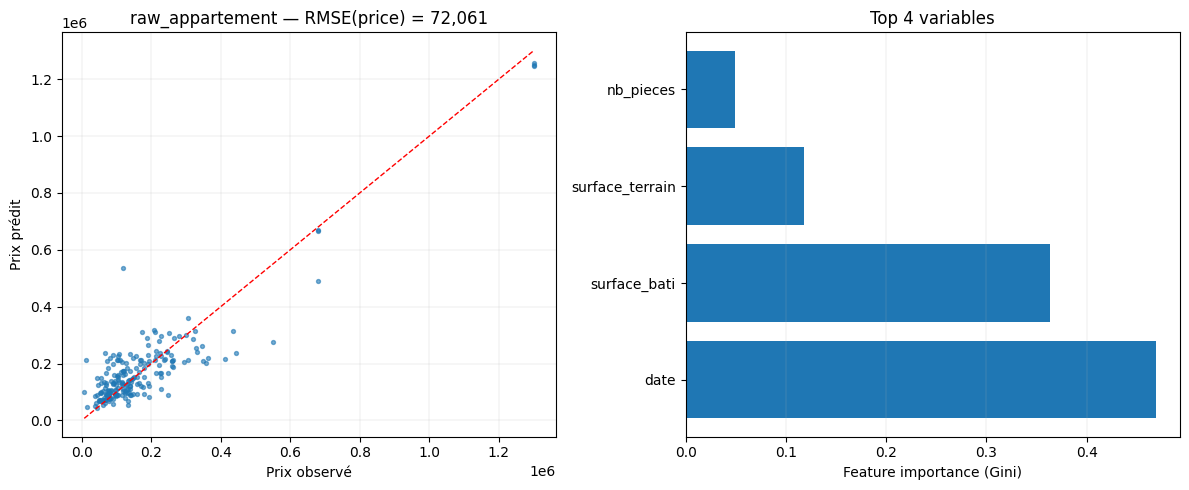

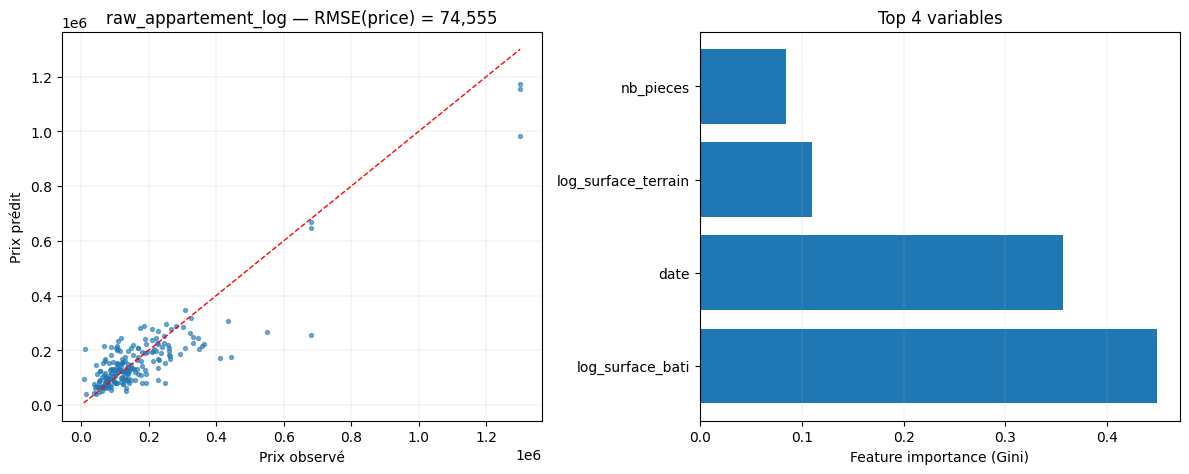

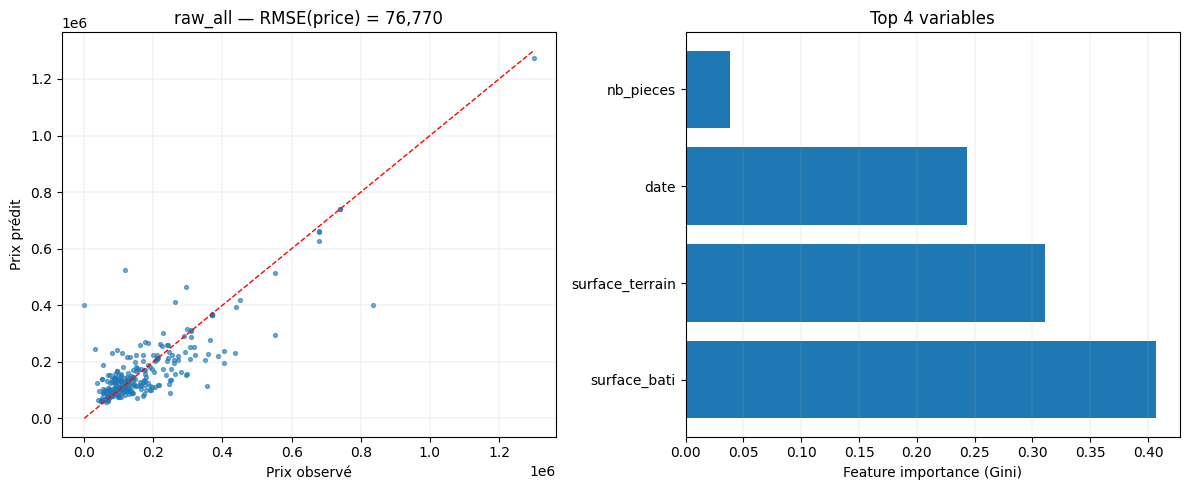

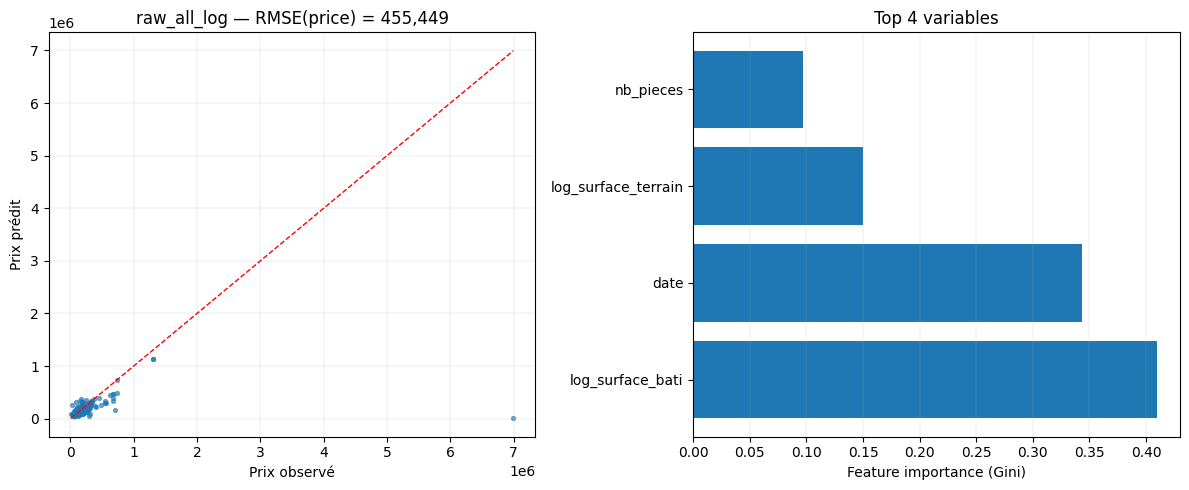

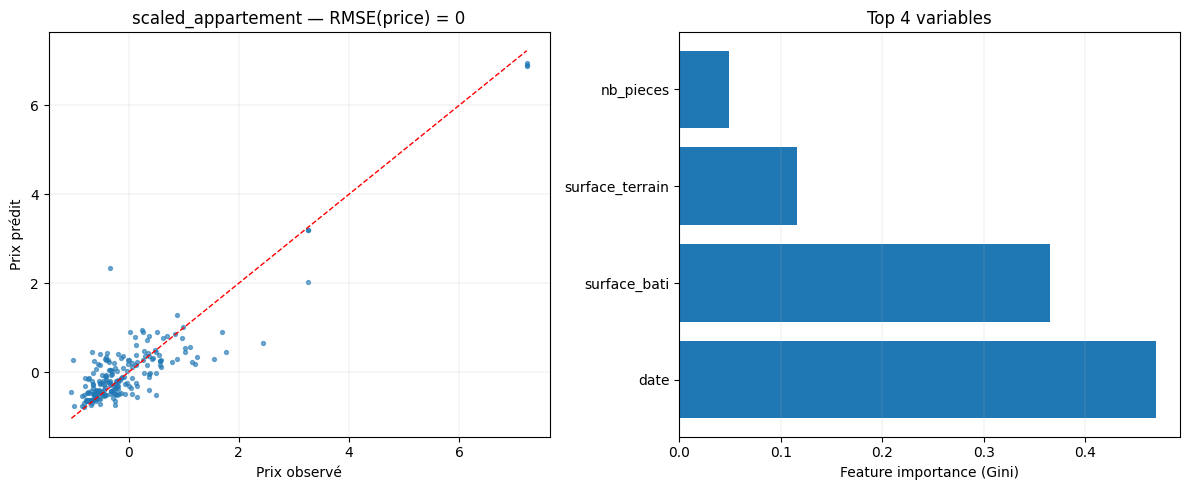

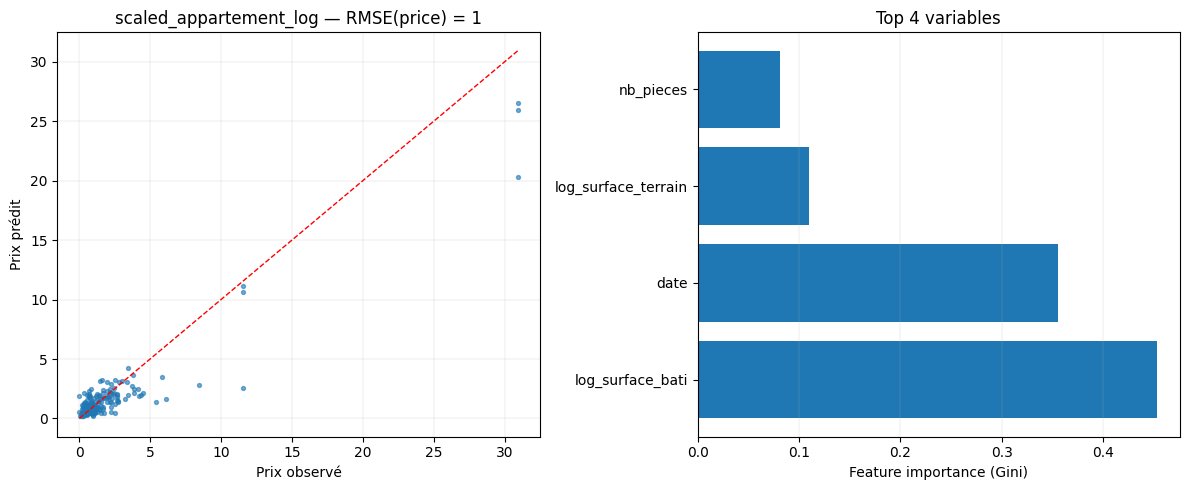

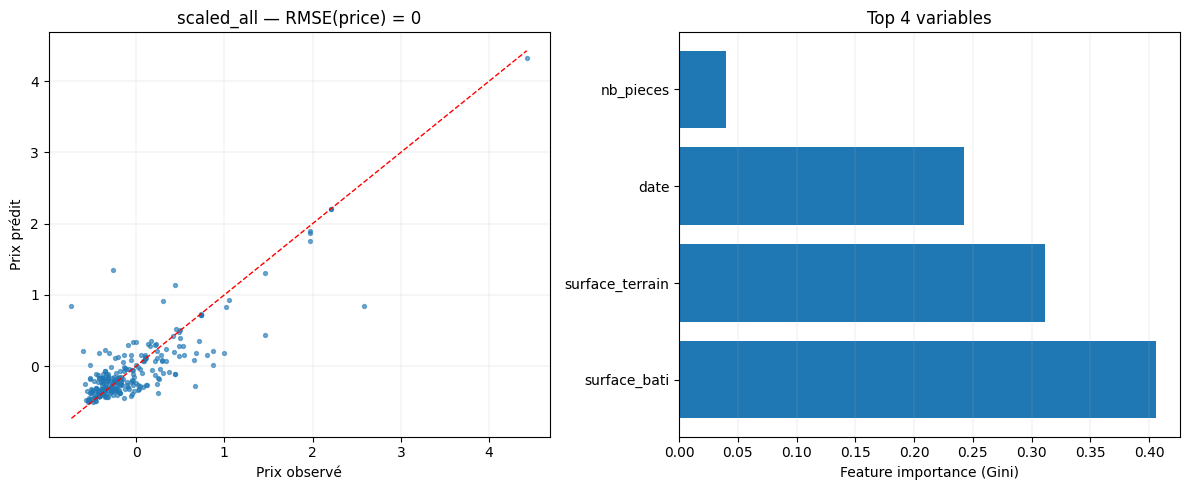

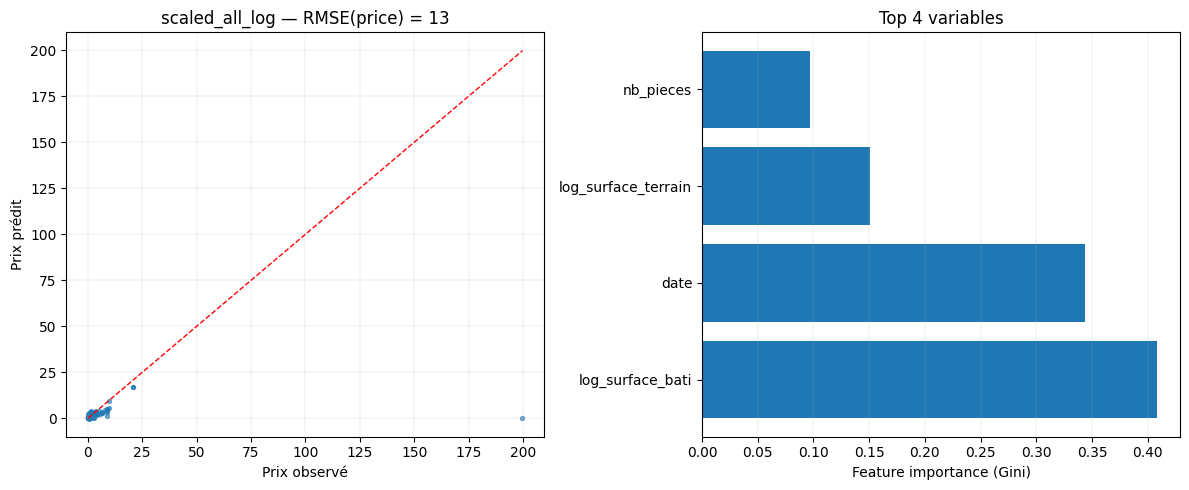

In [10]:
# Plot: actual vs predicted (price scale) and feature importance per model
for name, model in models.items():
    m = metrics[name]
    y_test = m['y_test']
    y_pred = m['y_pred']
    feat_names = m['features']
    importances = getattr(model, 'feature_importances_', np.zeros(len(feat_names)))
    plot_rf_results(name, y_test, y_pred, feat_names, importances, m['target'], top_k=15)

## 10. Conclusion
Le notebook met en place une chaîne RandomForest: préparation des données, variantes log/scaled, entraînement et diagnostics (graphiques et tableau synthétique).